# Modéle de prédiction de Charge de chauffage(y2)

In [7]:
### Importer les librairies python nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # pour enregistrer et téléchargé le modèle/ scaler 
import os

In [9]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.linear_model import  RANSACRegressor, TheilSenRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

## Importer datat de Y2

In [13]:
# Identifier mon répertoire de travail actuel
os.getcwd()
os.chdir(r"C:\Users\DHM\Downloads\y1Y2")
os.getcwd()

'C:\\Users\\DHM\\Downloads\\y1Y2'

In [15]:
#lire la base de données
data = pd.read_csv('ESTIMATIONy2.csv')
print(f" data.shape:{data.shape}")

 data.shape:(768, 9)


# À propos de la prédiction

### La source de la donnée provient de l'étude menée par Angeliki Xifara et Athanasios Tsanas, publiée dans le journal Energy and Buildings.

### Source de la donnée : La source de la donnée provient de l'étude menée par Angeliki Xifara et Athanasios Tsanas, publiée dans le journal Energy and Buildings.
### Titre de l'article: Accurate quantitative estimation of energy performance of residential buildings .

### Le dataset comporte 8 variables d'entrée (X1 à X8) utilisées pour prédire les charges énergétiques :

### X1 : Relative Compactness (Compacité relative)
### Unité : Sans unité (c'est un rapport ou un coefficient)
### X2 : Surface Area (Surface totale)
### Unité : m² (mètres carrés)
### X3 : Wall Area (Surface des murs)
### Unité : m² (mètres carrés)
### X4 : Roof Area (Surface du toit)
### Unité : m² (mètres carrés)
### X5 : Overall Height (Hauteur totale)
### Unité : m (mètres)
### X6 : Orientation
### Unité : Catégorique (représenté par des valeurs numériques correspondant à des orientations spécifiques, comme Nord, Sud, Est, Ouest)
### X7 : Glazing Area (Surface vitrée)
### Unité : m² (mètres carrés)
### X8 : Glazing Area Distribution (Répartition de la surface vitrée)
### Unité : Catégorique (valeurs numériques indiquant différentes répartitions de la surface vitrée, comme uniformément répartie ou concentrée sur certaines façades)
### Y2 : Cooling Load (Charge de refroidissement)
### Unité : kWh/m² (kilowattheures par mètre carré)

In [52]:
# Conversion des colonnes de type 'object' en 'float'
data = data.apply(lambda x: pd.to_numeric(x, errors='coerce') if x.dtype == 'object' else x)

# Affichage des types de colonnes pour vérifier la conversion
print(data.dtypes)

X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y2    float64
dtype: object


### Un aperçu Sur les variables 

In [12]:
# Vérifier s'il y a des données manquantes
data.isna().sum()

X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y2    0
dtype: int64

<Axes: >

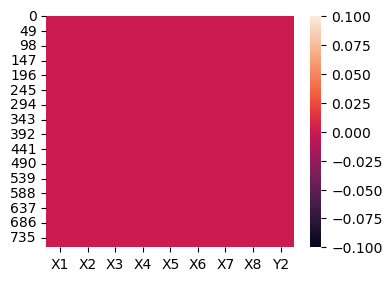

In [14]:
# Vérifier s'il y a des données manquantes:visualisation graphique
plt.figure(figsize=(4,3))
sns.heatmap(data.isna())

In [16]:
## Afficher un résumé des données
data.describe(include="all")

,X1,X2,X3,X4,X5,X6,X7,X8,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,48.030000


## interprétation 
### -X7  : (écart-type / moyenne)= 0,57 Indique une grande variabilité relative de la surface vitrée entre les bâtiments.
### -X8 : (écart-type / moyenne)= 0,55   Montre une forte dispersion dans la distribution de la surface vitrée.
### -X3 (Wall Area) : (écart-type / moyenne)= 0,137  Les surfaces murales varient peu en proportion de leur moyenne.
### -Les deux variables X1 et X4 sont relativement symétrique (La moyenne  et la médiane  sont très proches) 


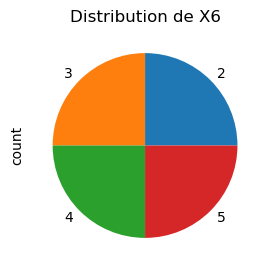

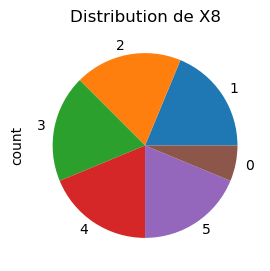

In [15]:
## Décrire les variables qualitatives séparément :
qualitative_vars=['X6',"X8"]
for col in qualitative_vars:
    plt.figure(figsize=(3,3))
    data[col].value_counts().plot(kind="pie") # ou : sns.countplot(x=col, data=data)
    plt.title(f"Distribution de {col}")
    plt.show()

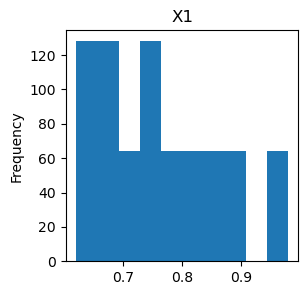

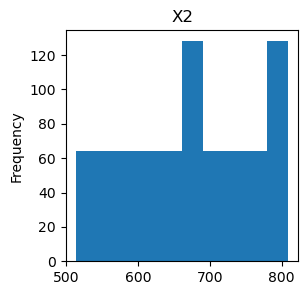

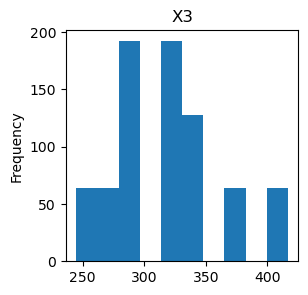

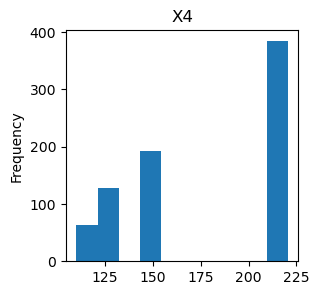

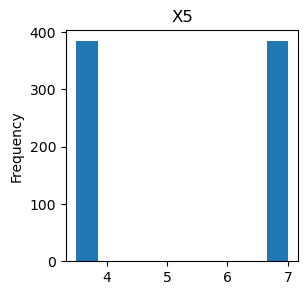

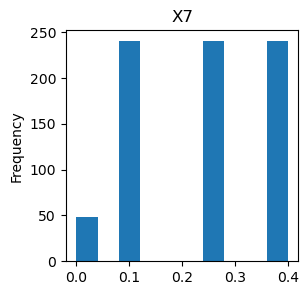

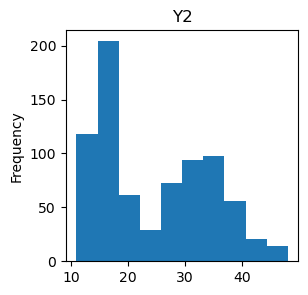

In [58]:
vars=['X1', 'X2', 'X3', 'X4', 'X5', 'X7',"Y2"]
for col in vars:
    plt.figure(figsize=(3,3))
    plt.title(f"{col}")
    data[col].plot(kind='hist')
    plt.show()

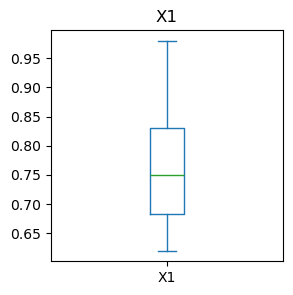

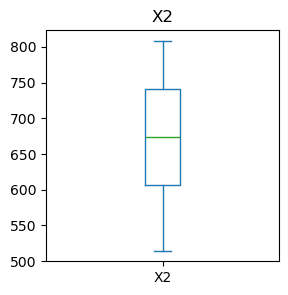

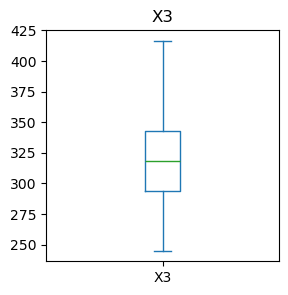

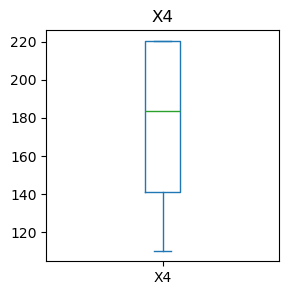

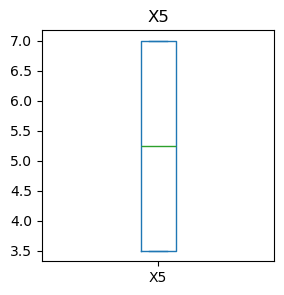

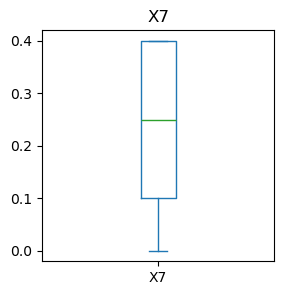

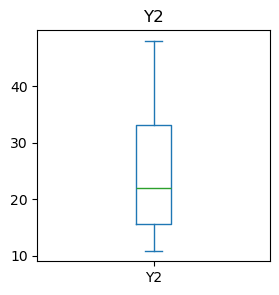

In [22]:
#Décrire les variables quantitative: identification des données aberrantes
vars=['X1', 'X2', 'X3', 'X4', 'X5', 'X7',"Y2"]
for col in vars:
    plt.figure(figsize=(3,3))
    plt.title(f"{col}")
    data[col].plot(kind='box')
    plt.show()

### On remarque que toutes les variables sont symétriques sauf Y2.

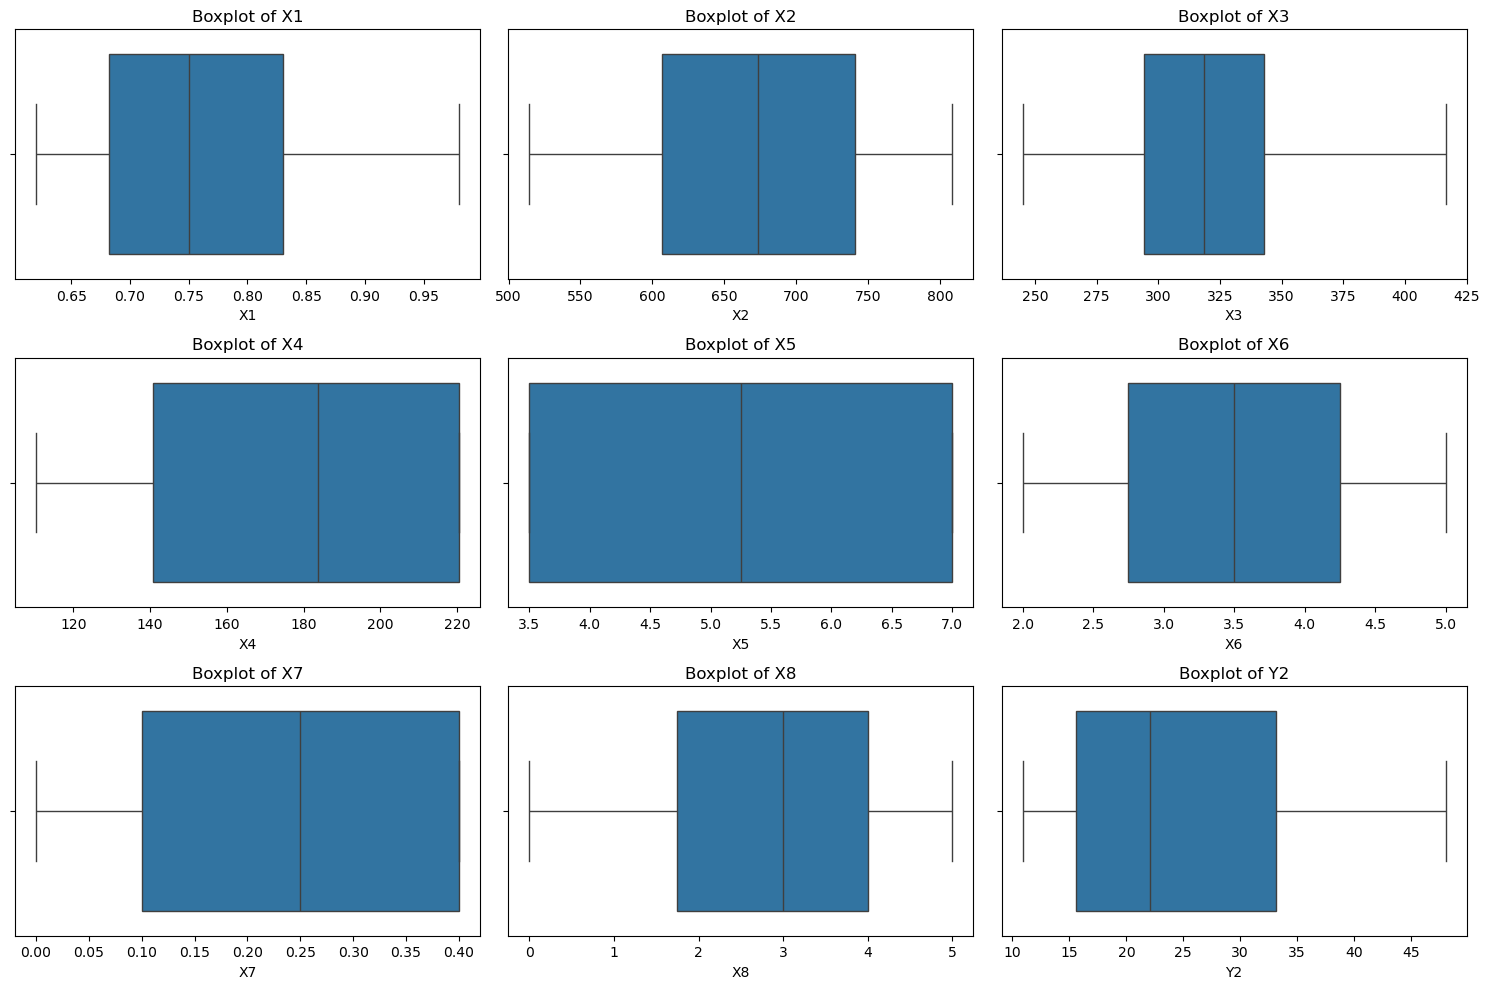

In [17]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(data.columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [11]:
## séparer la variables à expliquer et les variables explicatives
y=data["Y2"] # variable target  
X=data.drop(["Y2"],axis=1)

<Axes: >

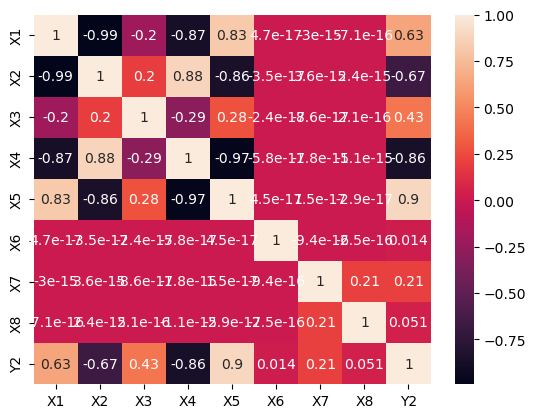

In [66]:
#afficher la matrice de corrélation
sns.heatmap(data.corr(),annot=True)


## on remarque qu il y a une faible corrélatin entre X6,X8 et Y2
## une corrélation négative enter X2,X4 et Y1
## fort corrélation  entre X5,X4 et Y1

# Sdandariser les données

In [19]:
from sklearn.preprocessing import StandardScaler
X.tail()

,X1,X2,X3,X4,X5,X6,X7,X8
763,0.64,784.0,343.0,220.5,3.5,5,0.4,5
764,0.62,808.5,367.5,220.5,3.5,2,0.4,5
765,0.62,808.5,367.5,220.5,3.5,3,0.4,5
766,0.62,808.5,367.5,220.5,3.5,4,0.4,5
767,0.62,808.5,367.5,220.5,3.5,5,0.4,5


In [13]:
#standardiser les variables explicatives non binaires
binary_data = X[["X6", "X8"]]  # Ajoutez les variables binaires ici
non_binary_data = X.drop(columns=["X6", "X8"])  # Exclure les variables binaires

scaler=StandardScaler()
Xs=scaler.fit_transform(non_binary_data)
# enregistrer le  scaler 
joblib.dump(scaler, 'scaler2.pkl') 

#transformer les données standardisées en dataframe
Xs=pd.DataFrame(Xs,columns=non_binary_data.columns,index=non_binary_data.index)
Xs_final=pd.concat([Xs,binary_data],axis=1) # ajouter les variables binaires à notre base de données standardisée
Xs_final = Xs_final[X.columns]  # Réorganiser les colonnes pour suivre l'ordre original

# Afficher les dernières lignes du DataFrame final

Xs_final.tail()

,X1,X2,X3,X4,X5,X6,X7,X8
763,-1.174613,1.275625,0.561951,0.972512,-1.0,5,1.244049,5
764,-1.363812,1.553943,1.123903,0.972512,-1.0,2,1.244049,5
765,-1.363812,1.553943,1.123903,0.972512,-1.0,3,1.244049,5
766,-1.363812,1.553943,1.123903,0.972512,-1.0,4,1.244049,5
767,-1.363812,1.553943,1.123903,0.972512,-1.0,5,1.244049,5


In [15]:
# Diviser la BDD initiale en BDD d'entrainement et BDd test
x_train,x_test,y_train,y_test=train_test_split(Xs_final,y,test_size=0.1,random_state=42)

In [25]:
print(x_train.shape)
print(x_test.shape)

(691, 8)
(77, 8)


# entrainer un modéle

### Fonction pour évaluer les modèles

In [44]:

def evaluate_model(model, x_train, y_train, x_test, y_test):
    # Entraîner le modèle et prédire
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    # Calculer les métriques
    MSE = mean_squared_error(y_test, pred)
    MAE = mean_absolute_error(y_test, pred)
    R2 = r2_score(y_test, pred)

    # Afficher les résultats
    print(f"Mean Absolute Error (MAE): {MAE:.6f}")
    print(f"Mean Squared Error (MSE): {MSE:.6f}")
    print(f"R-squared (R²): {R2:.6f}")

    # Graphique des prédictions vs valeurs réelles
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, pred, color='blue', label='Prédictions')
    x = np.linspace(min(y_train), max(y_train), 100)
    plt.plot(x, x, color='red', linestyle='--', label='y = x')
    plt.title('Valeurs Prédites vs Valeurs Réelles')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


## RANSAC model


Meilleurs paramètres pour RANSAC Regressor :
{'estimator__fit_intercept': True, 'max_trials': 100, 'residual_threshold': 5.0}

RANSAC Regressor:
Mean Absolute Error (MAE): 2.246098
Mean Squared Error (MSE): 11.656220
R-squared (R²): 0.882036


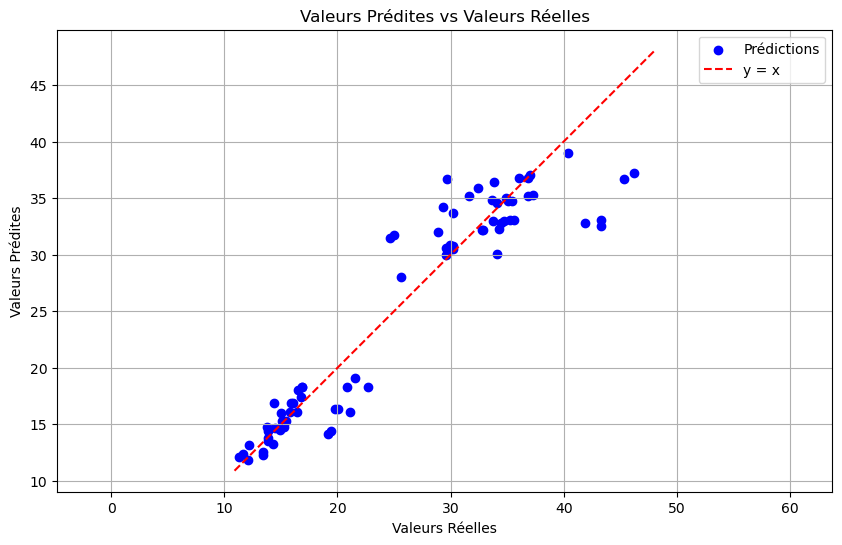

In [46]:

# Définir la grille des paramètres pour RANSAC
param_grid_ransac = {
    'estimator__fit_intercept': [True, False],  # Si le modèle linéaire doit inclure un intercept
    'residual_threshold': [1.0, 2.0, 5.0],  # Seuil de résidus
    'max_trials': [100, 200]  # Nombre d'essais pour la recherche du modèle
}

# Créer et entraîner le modèle RANSAC avec GridSearch
ransac = RANSACRegressor(estimator=LinearRegression())  # Utilisation d'un estimateur linéaire
grid_ransac = GridSearchCV(estimator=ransac, param_grid=param_grid_ransac, scoring='r2', cv=5)
grid_ransac.fit(x_train, y_train)

# Afficher les meilleurs paramètres de RANSAC
print("\nMeilleurs paramètres pour RANSAC Regressor :")
print(grid_ransac.best_params_)

# Évaluer le modèle avec les meilleurs paramètres
print("\nRANSAC Regressor:")
model_ransac = grid_ransac.best_estimator_
evaluate_model(model_ransac, x_train, y_train, x_test, y_test)

#  Theil-Sen Regressor


Meilleurs paramètres pour Theil-Sen Regressor :
{'fit_intercept': True, 'max_iter': 1000, 'tol': 0.001}

Theil-Sen Regressor:
Mean Absolute Error (MAE): 2.406592
Mean Squared Error (MSE): 11.965231
R-squared (R²): 0.878909


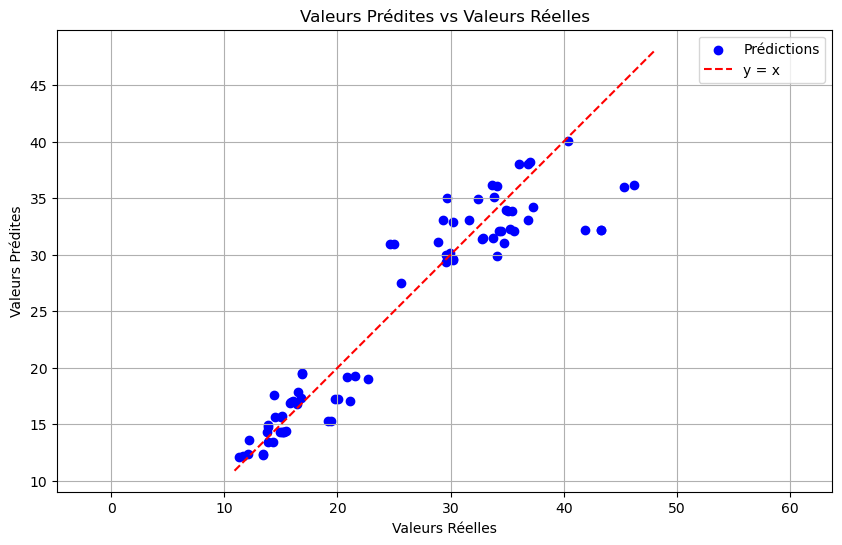

In [49]:

# Définir la grille des paramètres pour Theil-Sen
param_grid_theil_sen = {
    'max_iter': [1000, 2000],  # Nombre d'itérations pour l'optimisation
    'tol': [1e-4, 1e-3],  # Tolérance pour la convergence
    'fit_intercept': [True, False]  # Si le modèle linéaire doit inclure un intercept
}

# Créer et entraîner le modèle Theil-Sen avec GridSearch
theil_sen = TheilSenRegressor()
grid_theil_sen = GridSearchCV(estimator=theil_sen, param_grid=param_grid_theil_sen, scoring='r2', cv=5)
grid_theil_sen.fit(x_train, y_train)

# Afficher les meilleurs paramètres de Theil-Sen
print("\nMeilleurs paramètres pour Theil-Sen Regressor :")
print(grid_theil_sen.best_params_)

# Évaluer le modèle avec les meilleurs paramètres
print("\nTheil-Sen Regressor:")
model_theil_sen = grid_theil_sen.best_estimator_
evaluate_model(model_theil_sen, x_train, y_train, x_test, y_test)


## Régression Ridge

In [55]:
# Préciser les valeurs de lambda à tester 
nb_va=300
# donne des valeurs entre 10^(-3) et 10^(2)
lambda_values=np.logspace(-3,2,nb_va)
lambda_range={"alpha":lambda_values}

In [57]:
# modèle Ridge
modelR=Ridge()

In [61]:
grid=GridSearchCV(modelR,lambda_range,scoring="neg_mean_squared_error",
                  cv=5)
#'neg_mean_squared_error' à maximiser (à minimiser mse)

In [63]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.03925568e-03, 1.08005237e-03, 1.12245057e-03,
       1.16651313e-03, 1.21230540e-03, 1.25989528e-03, 1.30935333e-03,
       1.36075289e-03, 1.41417017e-03, 1.46968439e-03, 1.52737785e-03,
       1.58733611e-03, 1.64964807e-03, 1.71440614e-03, 1.78170632e-03,
       1.85164842e-03, 1.92433614e-03, 1.99987727e-03, 2....
       4.12462638e+01, 4.28654141e+01, 4.45481252e+01, 4.62968923e+01,
       4.81143084e+01, 5.00030684e+01, 5.19659730e+01, 5.40059328e+01,
       5.61259726e+01, 5.83292359e+01, 6.06189899e+01, 6.29986298e+01,
       6.54716840e+01, 6.80418197e+01, 7.07128478e+01, 7.34887289e+01,
       7.63735792e+01, 7.93716762e+01, 8.24874655e+01, 8.57255673e+01,
       8.90907830e+01, 9.25881025e+01, 9.62227117e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [65]:
# afficher la valeur optimal de lambda
grid.best_params_

{'alpha': 0.09771619672696176}

Mean Absolute Error (MAE): 2.314548
Mean Squared Error (MSE): 11.556047
R-squared (R²): 0.883050


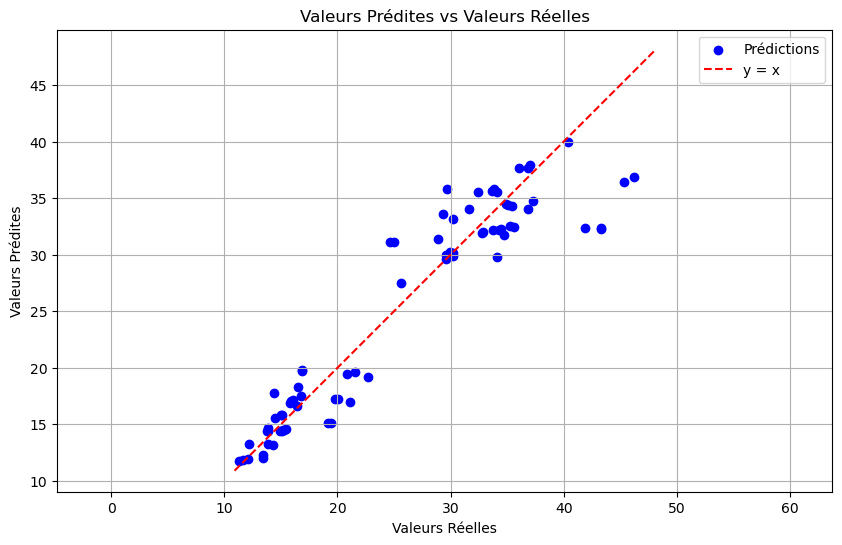

In [67]:
# Entrainer le modèle Ridge avec la valeur optimale de lambda séléctionnée
modelR1=grid.best_estimator_
evaluate_model(modelR1, x_train, y_train, x_test, y_test)


## Régression lasso

In [71]:
# préciser les valeurs de lambda à tester 
nb_va=300
lambda_values=np.logspace(-3,2,nb_va)
lambda_range={"alpha":lambda_values}
# modèle Lasso
modelL = Lasso(max_iter=10000)
grid=GridSearchCV(modelL,lambda_range,scoring='neg_mean_squared_error',cv=5)
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.03925568e-03, 1.08005237e-03, 1.12245057e-03,
       1.16651313e-03, 1.21230540e-03, 1.25989528e-03, 1.30935333e-03,
       1.36075289e-03, 1.41417017e-03, 1.46968439e-03, 1.52737785e-03,
       1.58733611e-03, 1.64964807e-03, 1.71440614e-03, 1.78170632e-03,
       1.85164842e-03, 1.92433614e-03, 1.9...
       4.12462638e+01, 4.28654141e+01, 4.45481252e+01, 4.62968923e+01,
       4.81143084e+01, 5.00030684e+01, 5.19659730e+01, 5.40059328e+01,
       5.61259726e+01, 5.83292359e+01, 6.06189899e+01, 6.29986298e+01,
       6.54716840e+01, 6.80418197e+01, 7.07128478e+01, 7.34887289e+01,
       7.63735792e+01, 7.93716762e+01, 8.24874655e+01, 8.57255673e+01,
       8.90907830e+01, 9.25881025e+01, 9.62227117e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [75]:
# afficher la valeur optimal de lambda
grid.best_params_

{'alpha': 0.001}

Mean Absolute Error (MAE): 2.314407
Mean Squared Error (MSE): 11.553883
R-squared (R²): 0.883072


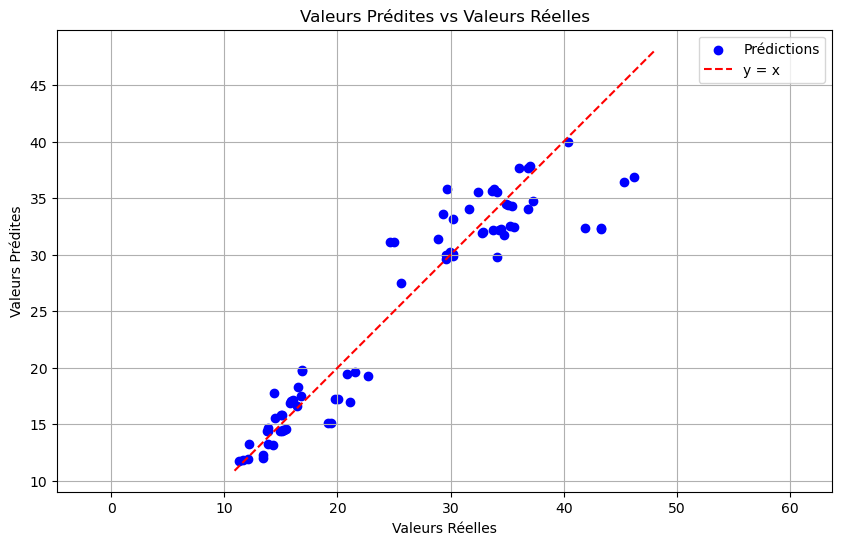

In [77]:
# Entrainer le modèle Ridge avec la valeur optimale de lambda séléctionnée
from sklearn.metrics import mean_absolute_error, r2_score

modelL1=grid.best_estimator_
evaluate_model(modelL1, x_train, y_train, x_test, y_test)


## Régression ElasticNet

In [79]:
nb_val=300 # nbr de valeurs à tester 
lambda_range=np.logspace(-3,2,nb_val) # valeurs de lambda à tester
rho_range=[0.1,0.01,0.001]    # valeurs de rho à tester  
hpers={"alpha":lambda_range,"l1_ratio":rho_range} 

In [81]:
model=ElasticNet(max_iter=10000)
grid=GridSearchCV(model,hpers,cv=5,scoring="neg_mean_squared_error")

In [83]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.03925568e-03, 1.08005237e-03, 1.12245057e-03,
       1.16651313e-03, 1.21230540e-03, 1.25989528e-03, 1.30935333e-03,
       1.36075289e-03, 1.41417017e-03, 1.46968439e-03, 1.52737785e-03,
       1.58733611e-03, 1.64964807e-03, 1.71440614e-03, 1.78170632e-03,
       1.85164842e-03, 1.92433614e-0...
       4.81143084e+01, 5.00030684e+01, 5.19659730e+01, 5.40059328e+01,
       5.61259726e+01, 5.83292359e+01, 6.06189899e+01, 6.29986298e+01,
       6.54716840e+01, 6.80418197e+01, 7.07128478e+01, 7.34887289e+01,
       7.63735792e+01, 7.93716762e+01, 8.24874655e+01, 8.57255673e+01,
       8.90907830e+01, 9.25881025e+01, 9.62227117e+01, 1.00000000e+02]),
                         'l1_ratio': [0.1, 0.01, 0.001]},
             scoring='neg_mean_squared_error')

In [87]:
# Afficher les valeurs optimales des hyperparamètres
grid.best_params_

{'alpha': 0.001, 'l1_ratio': 0.1}

Mean Absolute Error (MAE): 2.308553
Mean Squared Error (MSE): 11.556186
R-squared (R²): 0.883049


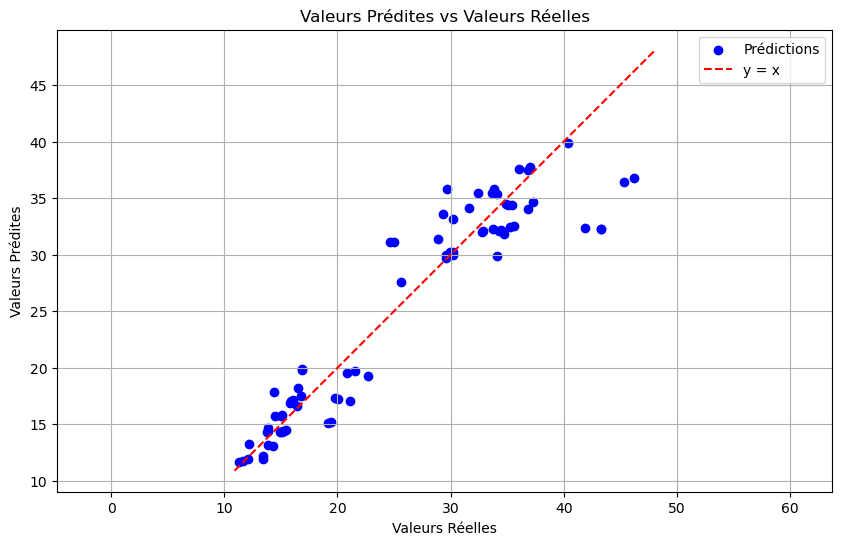

In [89]:
#Entrainer le modèle ElasticNet avec les valeurs optimales séléctionnées
# de lambda et de alpha 
model=grid.best_estimator_
evaluate_model(model, x_train, y_train, x_test, y_test)

# Prédiction

## on fait la prédicion avec le modél de lasso (plus grand R**2)

In [117]:
joblib.dump(modelL1, 'model2.pkl')

['model2.pkl']

In [119]:
# télécharger le  scaler enrigstré aupaavant 
scaler = joblib.load('scaler1.pkl')
scaler.feature_names_in_

array(['X1', 'X2', 'X3', 'X4', 'X5', 'X7'], dtype=object)

In [129]:
# Les nouvelles données de prédiction
new={
    'X1':[2, 3],
    'X2':[3,2],
    'X3':[70,50],
    'X4':[5,7],
    'X5':[1.5,1.7],
    'X6':[2,5],
    'X7':[5,70],
'X8':[0,9]
     }

df=pd.DataFrame(new)
# Charger le scaler enregistré
scaler = joblib.load('scaler1.pkl')

# Supposons que X_test est votre DataFrame contenant les nouvelles données à prédire
# Exemple de variables binaires et non binaires dans X_test
binary_variables = ["X6", "X8"]  # Variables binaires
non_binary_variables = df.drop(columns=binary_variables)  # Exclure les variables binaires

# Standardiser les variables non binaires
dfstand = scaler.transform(non_binary_variables)

# Transformer les données standardisées en DataFrame
dfstand = pd.DataFrame(dfstand, columns=non_binary_variables.columns, index=non_binary_variables.index)

# Ajouter les variables binaires au DataFrame standardisé
Xs_test_final = pd.concat([dfstand, df[binary_variables]], axis=1)

# Réorganiser les colonnes pour suivre l'ordre original (optionnel)
Xs = Xs_test_final[df.columns]

# Charger le modèle Lasso (si ce n'est pas déjà fait)
modelL = joblib.load('model2.pkl')  # Remplacez 'model_lasso.pkl' par le nom de votre fichier de modèle

# Faire des prédictions
predictions = modelL.predict(Xs)

# Afficher les résultats
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])
print(predictions_df.head())  # Afficher les premières prédictions


   Predictions
0    39.963367
1   933.642746
